# -----: Importing necessary libraries -----

In [1]:
import praw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Scraping Data from Reddit ---

In [2]:
reddit = praw.Reddit(
    client_id="fjoMsFpdDUwNznfbHI_Phw",
    client_secret="8YPEzjT7MKo0OUYcIqHuSG0RZmNsng",
    user_agent="StockMovementPredictor/0.1"
)

posts = []
subreddit = reddit.subreddit('stocks')
for post in subreddit.hot(limit=1000):  # Adjust limit as needed
    posts.append({
        'title': post.title,
        'author': post.author.name if post.author else None,
        'score': post.score,
        'num_comments': post.num_comments,
        'created': post.created_utc
    })

df = pd.DataFrame(posts)

# --- Step 2: Data Preprocessing ---

In [3]:
# Convert 'created' to datetime
df['created'] = pd.to_datetime(df['created'], unit='s')

# Extract day of the week and time of day
df['day_of_week'] = df['created'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['time_of_day'] = df['created'].dt.hour

# Calculate comment-to-score ratio
df['comment_to_score_ratio'] = np.where(df['score'] > 0, df['num_comments'] / df['score'], 0)

# --- Step 3: Sentiment Analysis using VADER ---

In [4]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['positive_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df['negative_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df['neutral_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['neu'])

# Calculate overall sentiment weight
df['weighted_sentiment'] = (df['positive_sentiment'] - df['negative_sentiment']) * df['score']

# Generate target variable (stock_movement) - Example
df['stock_movement'] = (df['score'] + df['num_comments'] * 0.5 + df['sentiment_score'] * 100).apply(round)

# Drop rows with missing data
df.dropna(inplace=True)

# --- Step 4: Exploratory Data Analysis (EDA) ---

In [5]:
## Summary Statistics of the Data
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
             score  num_comments                        created  day_of_week  \
count   192.000000    192.000000                            192   192.000000   
mean    144.229167     77.692708  2024-11-18 06:56:15.848958208     2.322917   
min       0.000000      0.000000            2024-11-11 07:18:54     0.000000   
25%       5.000000     11.000000     2024-11-13 21:51:28.500000     1.000000   
50%      30.000000     38.500000            2024-11-18 15:44:12     2.000000   
75%     126.250000     85.000000            2024-11-21 23:04:38     4.000000   
max    9722.000000    764.000000            2024-11-26 18:22:52     6.000000   
std     710.815378    112.987347                            NaN     1.807459   

       is_weekend  time_of_day  comment_to_score_ratio  sentiment_score  \
count  192.000000   192.000000              192.000000       192.000000   
mean     0.140625    14.562500                2.373813         0.086005   
min      0.000000     0.000000    

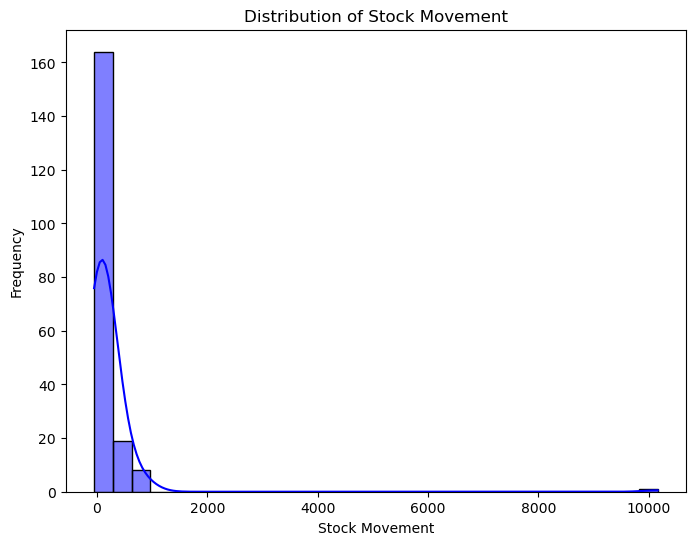

In [6]:
## Visualize Distribution of Stock Movement (Target Variable)
plt.figure(figsize=(8, 6))
sns.histplot(df['stock_movement'], kde=True, bins=30, color='blue')
plt.title('Distribution of Stock Movement')
plt.xlabel('Stock Movement')
plt.ylabel('Frequency')
plt.show()

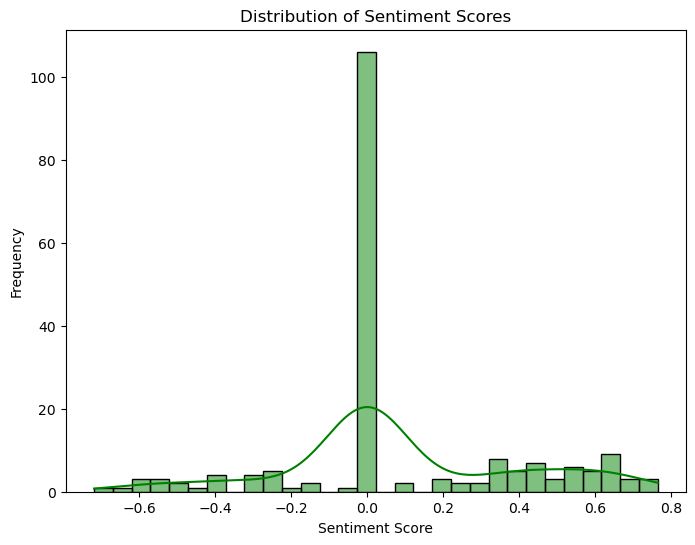

In [7]:
## Visualize Distribution of Sentiment Scores
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment_score'], kde=True, bins=30, color='green')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

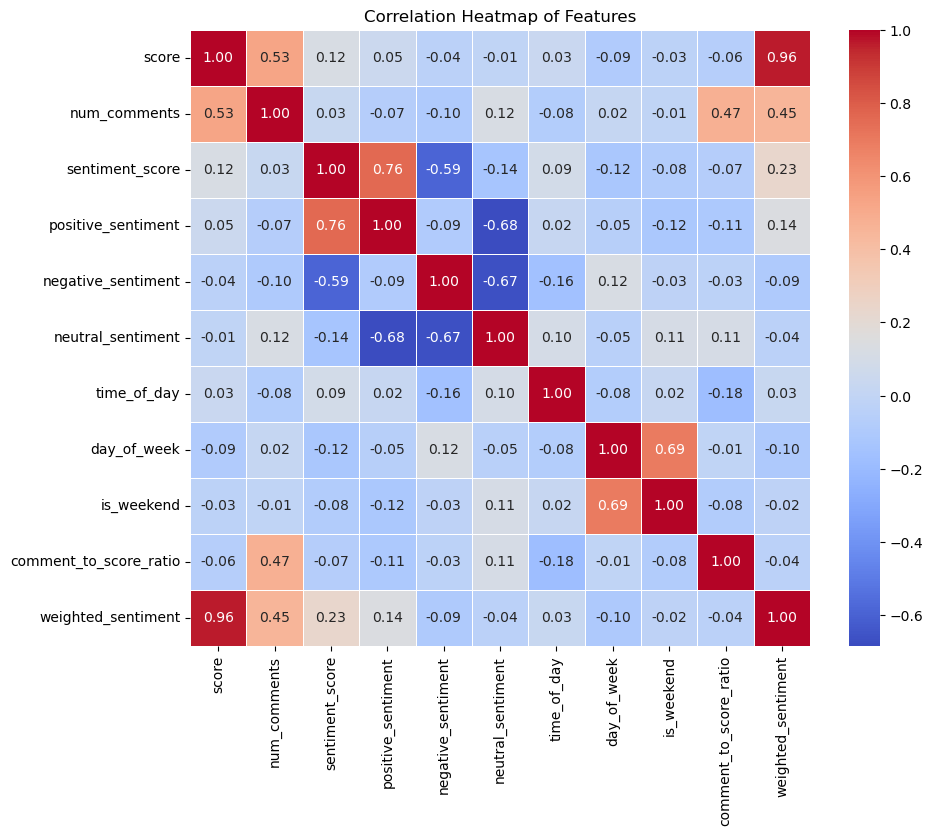

In [8]:
## Correlation Heatmap to Understand Relationships Between Features
correlation_matrix = df[['score', 'num_comments', 'sentiment_score', 'positive_sentiment', 
                         'negative_sentiment', 'neutral_sentiment', 'time_of_day', 'day_of_week', 
                         'is_weekend', 'comment_to_score_ratio', 'weighted_sentiment']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

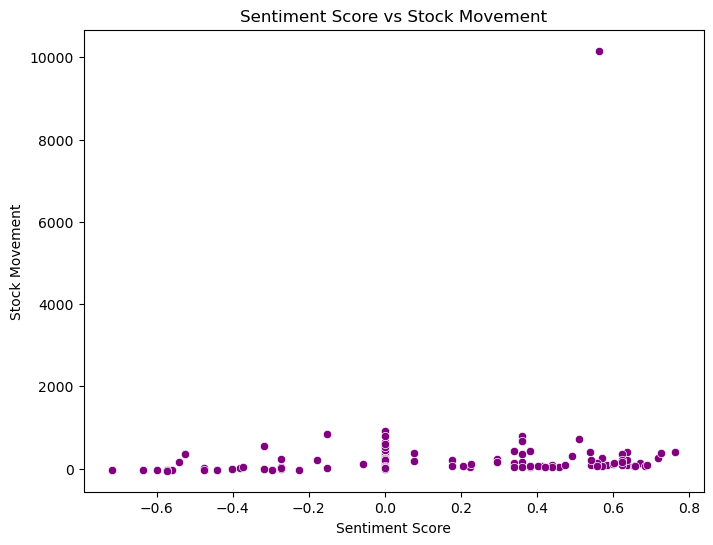

In [9]:
## Visualizing Sentiment vs Stock Movement
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment_score', y='stock_movement', data=df, color='purple')
plt.title('Sentiment Score vs Stock Movement')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Movement')
plt.show()

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_14012\3504448159.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.index, y=top_features.values, palette='viridis')


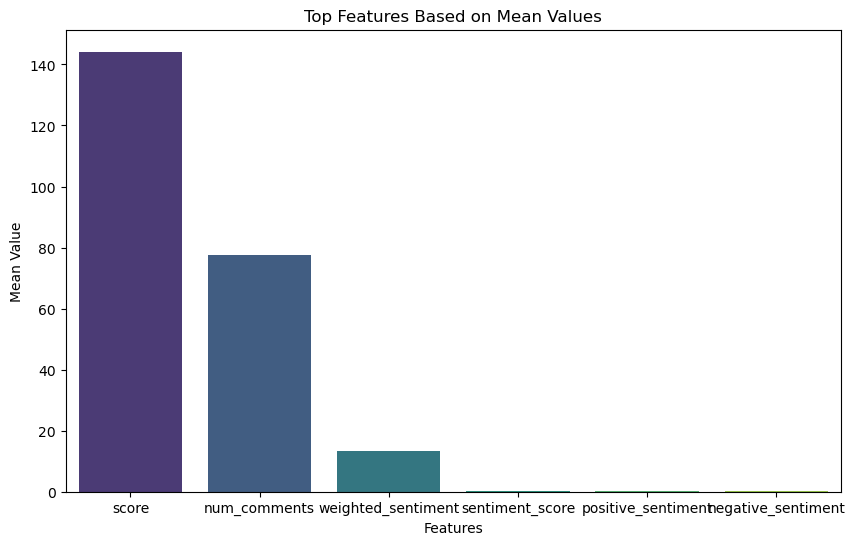

In [10]:
## Visualize Top Features Based on Sentiment and Engagement
top_features = df[['score', 'num_comments', 'sentiment_score', 'positive_sentiment', 'negative_sentiment', 'weighted_sentiment']].mean()
top_features = top_features.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.index, y=top_features.values, palette='viridis')
plt.title('Top Features Based on Mean Values')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.show()

# --- Step 5: Feature and Target Selection ---

In [11]:
features = [
    'score', 'num_comments', 'sentiment_score', 'positive_sentiment', 'negative_sentiment',
    'neutral_sentiment', 'time_of_day', 'day_of_week', 'is_weekend',
    'comment_to_score_ratio', 'weighted_sentiment'
]
X = df[features]
y = df['stock_movement']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 6: Model Building with XGBoost ---

In [12]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.01],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [ 0.5],
    'colsample_bytree': [0.7, 0.8, 1.0],
    }

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5}


# --- Step 7: Model Evaluation ---

In [13]:
y_pred = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)*100

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Mean Absolute Error (MAE): 36.17594610116421
Root Mean Squared Error (RMSE): 47.96464227396647
R² Score: 94.47124520162296


C:\Users\Nasreen RPX\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



# --- Step 8: Visualizations of Model Evaluation ---

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_14012\4139796530.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


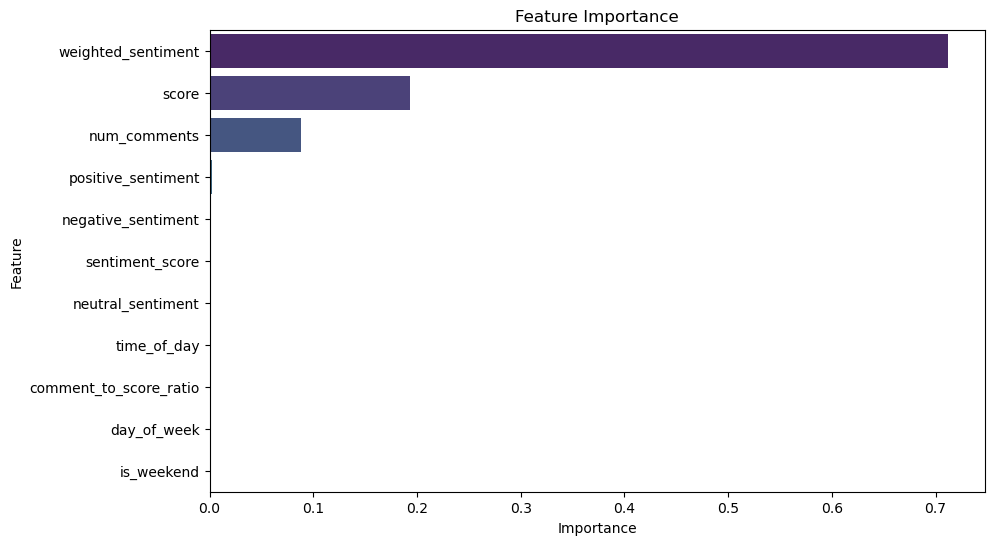

In [14]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

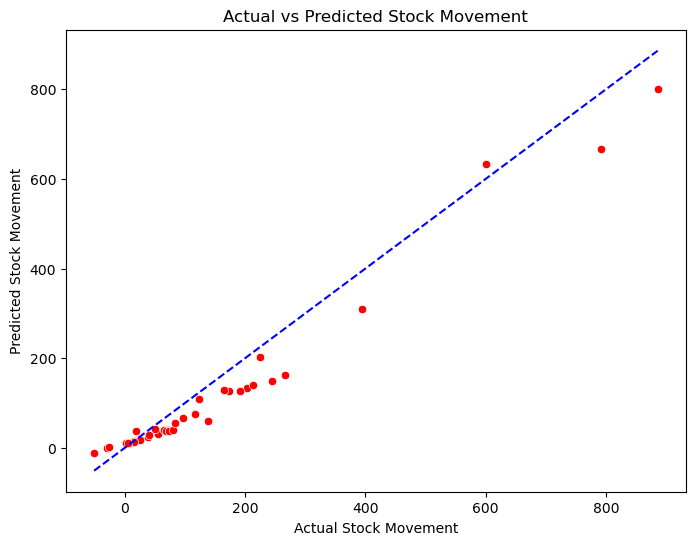

In [15]:
# Actual vs Predicted Stock Movement
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='blue')
plt.title('Actual vs Predicted Stock Movement')
plt.xlabel('Actual Stock Movement')
plt.ylabel('Predicted Stock Movement')
plt.show()

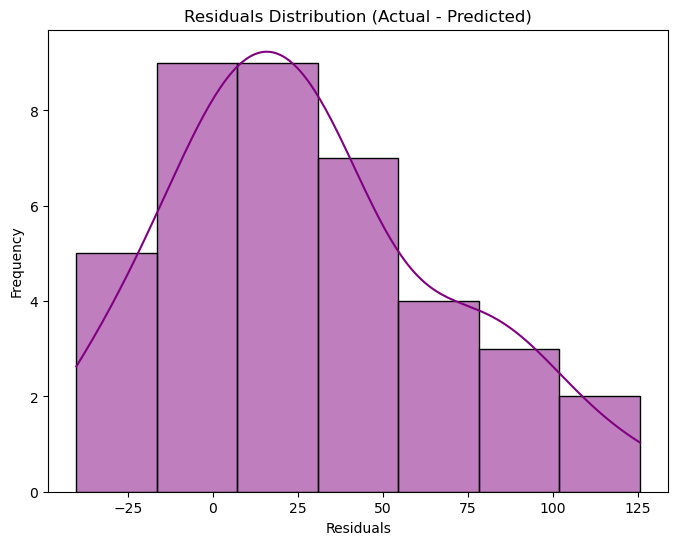

In [16]:
# Residuals Plot (difference between actual and predicted values)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

C:\Users\Nasreen RPX\AppData\Local\Temp\ipykernel_14012\1452396013.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')


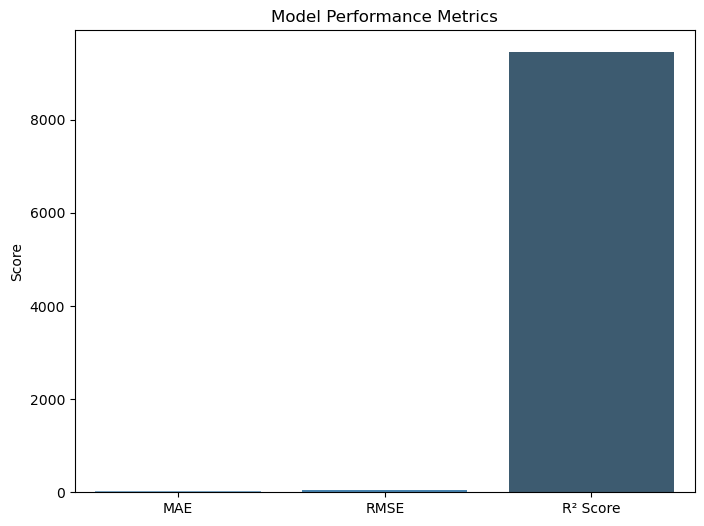

In [17]:
# Convert to percentage
r2_percent = r2 * 100

# Bar plot for model performance metrics
metrics = {'MAE': mae, 'RMSE': rmse, 'R² Score': r2_percent}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Blues_d')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

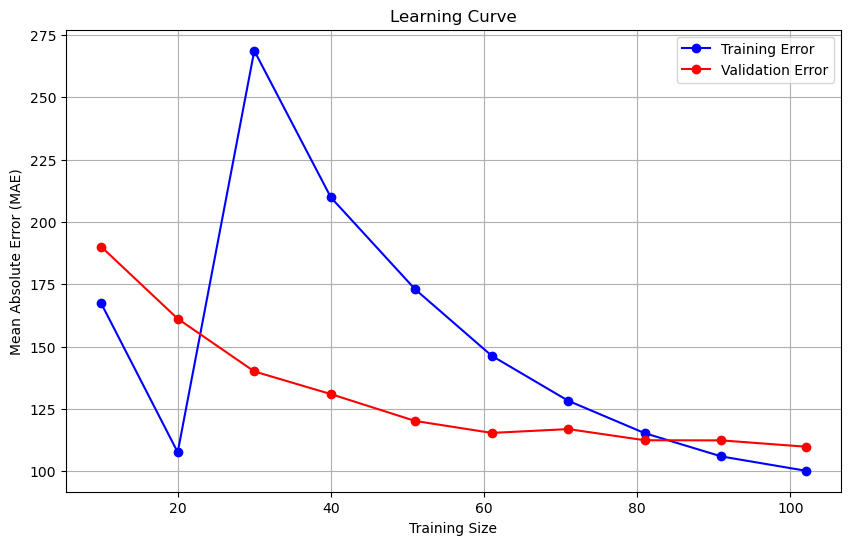

In [18]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_xgb_model, 
    X=X_train, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # Train with 10% to 100% of the data
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',  # Use MAE as scoring metric
    n_jobs=-1  # Use all available cores for computation
)

# Calculate mean and standard deviation of train and validation scores
train_mean = -train_scores.mean(axis=1)  # We negate to convert negative MAE to positive
val_mean = -val_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Error', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Validation Error', color='red', marker='o')

# Plot formatting
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc='best')
plt.grid(True)
plt.show()
